# Benchmarking Long-Short Term Memory (LSTM) on Chaotic Oscillators

This repository contains the code for benchmarking the performance of Long-Short Term Memory (LSTM) networks on chaotic oscillators. The LSTM is a type of Recurrent Neural Network (RNN) that is capable of learning long-term dependencies in sequential data.

  - [Lorenz](###Lorenz)
  - [Fibonacci](###Fibonacci)
  - [Van Der Pol](###Van-Der-Pol)

## Setup


In [1]:
import os
import sys
import torch

project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)

try:
    from src.utils.seed_utils import set_global_seeds
except ImportError:
    raise ImportError("Cannot import module. Make sure that the project is on the path")

SEED = 42
set_global_seeds(seed=SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Generate & Preprocess Data for Model


In [2]:
BATCH_SIZE = 32

### Lorenz


Train size: 39961, Test size: 9991, Batch size: 32


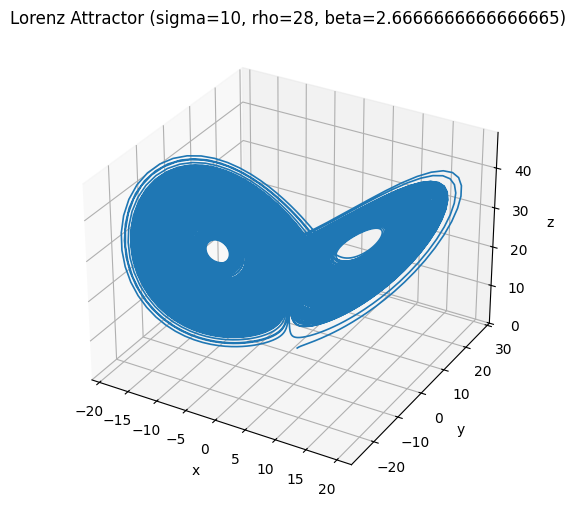

(<Figure size 800x600 with 1 Axes>,
 <Axes3D: title={'center': 'Lorenz Attractor (sigma=10, rho=28, beta=2.6666666666666665)'}, xlabel='x', ylabel='y', zlabel='z'>)

In [3]:
from src.data_sources.lorenz import LorenzOscillator
from src.utils.dataset_utils import DatasetUtils

# For model feed
LORENZ_INPUT_LAYERS = 3
LORENZ_OUTPUT_LAYERS = 3

# Parameters for the Lorenz oscillator
initial_state = [1.0, 1.0, 1.0]
t_span = (0, 500)
max_step = 1e-2

lorenz = LorenzOscillator(sigma=10, rho=28, beta=8.0 / 3.0)

# Create the dataset
dataset = lorenz.preprocess_and_create_dataset(
    initial_state=initial_state,
    t_span=t_span,
    max_step=max_step,
    input_length=50,
    target_length=1,
)

# Split the dataset
lorenz_train_dataset, lorenz_test_dataset = DatasetUtils().train_test_split(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    train_ratio=0.8,
    shuffle_train=True,
    shuffle_test=False,
)

# Visualize dataset
lorenz.plot_trajectory(initial_state=initial_state, t_span=t_span, max_step=max_step)

## LSTM


#### Training

In [4]:
from src.models.lstm import LSTM
from src.utils.torch_utils import criterion_choice
import torch
from torch.utils.tensorboard import SummaryWriter
from src.schemas.paths_schema import PathsSchema
from tqdm import tqdm
from src.utils.tensorboard_utils import launch_tensorboard

# Hyperparameters
hidden_size = 128
num_layers = 3
dropout = 0.2
loss_function = "mse"
learning_rate = 1e-6
num_epochs = 1000
max_grad_norm = 1.0  # for gradient clipping
step_size = 200  # for lr scheduler
gamma = 0.5  # lr multiplier at each step

# Model setup
model = LSTM(
    LORENZ_INPUT_LAYERS, hidden_size, num_layers, LORENZ_OUTPUT_LAYERS, dropout
).to(device)
criterion = criterion_choice(loss_function)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# For tensorboard logs
paths = PathsSchema(
    model_name=os.path.join(
        "lorenz",
        "lstm",
        f"seed_{SEED}_batch_size_{BATCH_SIZE}_input_{LORENZ_INPUT_LAYERS}"
        f"_hidden_{hidden_size}_layers_{num_layers}_dropout_{dropout}_loss_{loss_function}"
        f"_lr_{learning_rate}_num_epochs_{num_epochs}_clipping_{max_grad_norm}"
        f"_sched_step_{step_size}_gamma_{gamma}",
    )
)
writer = SummaryWriter(log_dir=paths.tensorboard_log_model)

# Display model graph in tensorboard
# dummy_input = torch.randn(1, 10, input_size).to(device)
# writer.add_graph(lstm, dummy_input)

launch_tensorboard(paths.tensorboard_log_model)

for epoch in tqdm(range(num_epochs)):
    # Training
    model.train()
    train_loss = 0

    for x, y in lorenz_train_dataset:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x)  # shape (batch_size, output_size)
        loss = criterion(outputs, y)  # y shape (batch_size, 1, output_size)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()

        train_loss += loss.item()

    scheduler.step()

    avg_train_loss = train_loss / len(lorenz_train_dataset)

    # Evaluation
    model.eval()
    test_loss = 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for x, y in lorenz_test_dataset:
            x, y = x.to(device), y.to(device)

            outputs = model(x)
            loss = criterion(outputs, y.squeeze(dim=1))

            test_loss += loss.item()

    avg_test_loss = test_loss / len(lorenz_test_dataset)

    writer.add_scalars("Loss", {"train": avg_train_loss, "test": avg_test_loss}, epoch)

    # For debugging, log lr evolution
    current_lr = scheduler.get_last_lr()[0]
    writer.add_scalar("Learning Rate", current_lr, epoch)

    if (epoch + 1) % (num_epochs // 10) == 0:
        print(
            f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, LR: {current_lr}"
        )

writer.close()

torch.save(
    model.state_dict(),
    paths.model_path
    + f"epoch_{epoch}_train_loss_{avg_train_loss:.4f}_test_loss_{avg_test_loss:.4f}.pt",
)

Renamed directory: /home/juanm/OneDrive/Bureau/Etudes/CY Paris/Projets/IAR_SilentSpeechRecognition/notebooks/tensorboard/lorenz/lstm/seed_42_batch_size_32_input_3_hidden_128_layers_3_dropout_0.2_loss_mse_lr_1e-06_num_epochs_1000_clipping_1.0_sched_step_200_gamma_0.5 -> /home/juanm/OneDrive/Bureau/Etudes/CY Paris/Projets/IAR_SilentSpeechRecognition/notebooks/tensorboard/lorenz/lstm/seed_42_batch_size_32_input_3_hidden_128_layers_3_dropout_0.2_loss_mse_lr_1e-06_num_epochs_1000_clipping_1.0_sched_step_200_gamma_0.5_20250104_134235



NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784



TensorBoard started at http://localhost:6006/


  0%|          | 0/1000 [00:00<?, ?it/s]

Opening in existing browser session.


/home/juanm/miniconda3/envs/IAR_SSR/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32, 1, 3])) that is different to the input size (torch.Size([32, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/juanm/miniconda3/envs/IAR_SSR/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([25, 1, 3])) that is different to the input size (torch.Size([25, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 100/1000 [04:07<36:32,  2.44s/it]

Epoch 100/1000, Train Loss: 0.0355, Test Loss: 0.0347, LR: 1e-06


 20%|██        | 200/1000 [08:08<32:23,  2.43s/it]

Epoch 200/1000, Train Loss: 0.0354, Test Loss: 0.0345, LR: 5e-07


 30%|███       | 300/1000 [12:12<28:07,  2.41s/it]

Epoch 300/1000, Train Loss: 0.0354, Test Loss: 0.0344, LR: 5e-07


 40%|████      | 400/1000 [16:12<23:51,  2.39s/it]

Epoch 400/1000, Train Loss: 0.0354, Test Loss: 0.0342, LR: 2.5e-07


 50%|█████     | 500/1000 [20:12<20:39,  2.48s/it]

Epoch 500/1000, Train Loss: 0.0354, Test Loss: 0.0342, LR: 2.5e-07


 60%|██████    | 600/1000 [24:12<15:39,  2.35s/it]

Epoch 600/1000, Train Loss: 0.0354, Test Loss: 0.0341, LR: 1.25e-07


 70%|███████   | 700/1000 [28:07<11:40,  2.34s/it]

Epoch 700/1000, Train Loss: 0.0354, Test Loss: 0.0341, LR: 1.25e-07


 80%|████████  | 800/1000 [32:02<07:49,  2.35s/it]

Epoch 800/1000, Train Loss: 0.0354, Test Loss: 0.0341, LR: 6.25e-08


 90%|█████████ | 900/1000 [35:57<03:54,  2.34s/it]

Epoch 900/1000, Train Loss: 0.0354, Test Loss: 0.0341, LR: 6.25e-08


100%|██████████| 1000/1000 [39:58<00:00,  2.40s/it]

Epoch 1000/1000, Train Loss: 0.0354, Test Loss: 0.0341, LR: 3.125e-08


### Evaluation

#### Multi-Step Evaluation

Sample #1:
  True: [0.9007395  0.6736734  0.87137234]
  Pred: [0.49408835 0.48731592 0.48959553]


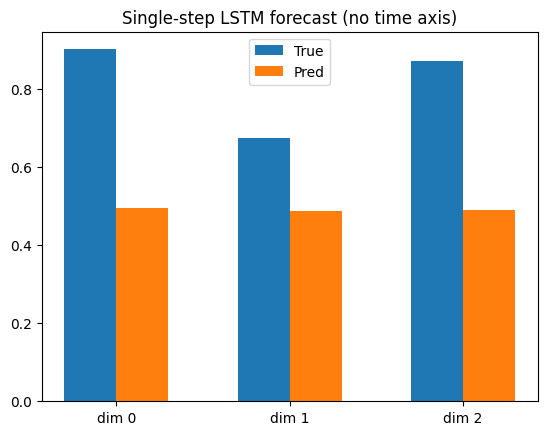

Sample #2:
  True: [0.09029236 0.0850668  0.6130321 ]
  Pred: [0.4694415  0.46864304 0.4816999 ]


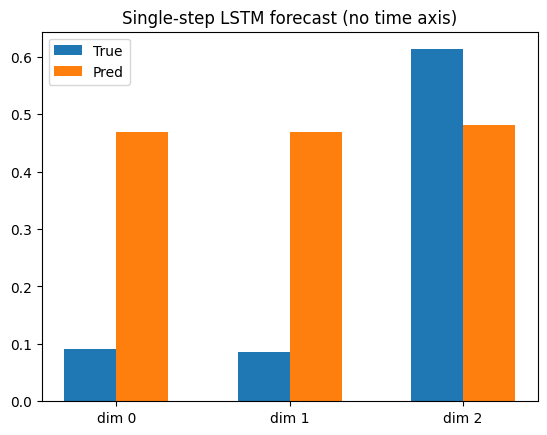

Sample #3:
  True: [0.93650925 0.7931098  0.82995075]
  Pred: [0.49450278 0.4876747  0.4871737 ]


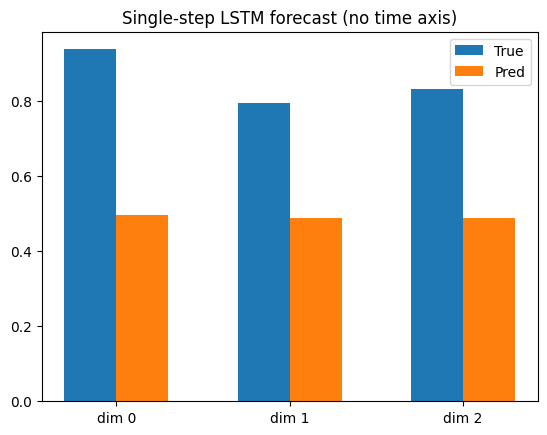

In [15]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()

num_plots = 3
samples_plotted = 0

for x_batch, y_batch in lorenz_test_dataset:
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

    with torch.no_grad():
        # shape (batch_size, output_dim)
        outputs = model(x_batch)

    # Convert to numpy
    outputs_np = outputs.detach().cpu().numpy()   # (batch_size, out_dim)
    y_true_np  = y_batch.detach().cpu().numpy()   # shape depends on your dataset

    # If y_batch is shaped (batch_size, out_dim), then you can directly compare.
    # If y_batch is shaped (batch_size, 1, out_dim), you might need y_batch.squeeze(1).
    if y_true_np.ndim == 3:
        y_true_np = y_true_np.squeeze(1)  # (batch_size, out_dim)

    batch_size = outputs_np.shape[0]

    for b in range(batch_size):
        if samples_plotted >= num_plots:
            break

        pred_point = outputs_np[b]  # shape (out_dim,)
        true_point = y_true_np[b]   # shape (out_dim,)

        print(f"Sample #{samples_plotted+1}:")
        print("  True:", true_point)
        print("  Pred:", pred_point)

        # If out_dim == 3 (like Lorenz x,y,z), just plot them as bar or side-by-side
        # There's no time axis, so a line plot doesn't make sense for a single step.

        fig, ax = plt.subplots()
        idx = np.arange(len(pred_point))
        width = 0.3

        ax.bar(idx - width/2, true_point, width, label="True")
        ax.bar(idx + width/2, pred_point, width, label="Pred")
        ax.set_xticks(idx)
        ax.set_xticklabels([f"dim {i}" for i in idx])
        ax.legend()
        plt.title("Single-step LSTM forecast (no time axis)")
        plt.show()

        samples_plotted += 1